# Исследование объявлений о продаже квартир

**Входные данные**:  архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет (данные сервиса Яндекс.Недвижимость)

**Цель исследования**: научиться определять рыночную стоимость объектов недвижимости. 

**Задача проекта**:  предобработка и исследовательский анализ данных. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

*Описание данных:*
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

*Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Содержание:
1. [Предобработка данных](#preprocessing)

    1.1. [Исходные данные](#raw_data)

    1.2. [Поиск аномалий и обработка пропущенных значений](#fill_na)

    * [`is_apartment` - удаление столбца](#is_apartment)
    * [`last_price` - удаление выбросов](#last_price)
    * [`total_area`, `living_area`, `kitchen_area` - устранение аномалий и выбросов](#area)
    * [`balcony` - заполнение NaN](#balcony)
    * [`floors_total` - заполнение пропущенных значений, исправление аномалий, удаление выбросов](#floors_total)
    * [`ceiling_height` - удаление аномалий и заполнение пропущенных значений](#ceiling_height)
    * [`rooms`, `studio`, `open_plan` - удаление аномалий](#planirovka)
    * [`floor`](#floor)
    * [`locality_name` - преобразование столбца](#locality_name_1)
    * [`airports_nearest` - заполнение пропусков](#airports_nearest)
    * [`cityCenters_nearest`  - заполнение пропусков](#cityCenters_nearest)
    * [`locality_name` - замена пропущенных значений](#locality_name_2)
    * [`parks_around3000`, `parks_nearest` - замена пропущенных значений](#parks)
    * [`ponds_around3000`, `ponds_nearest` - замена пропущенных значений](#ponds)
    * [`first_day_exposition`](#first_day_exposition)
    * [`days_exposition`](#days_exposition)

    1.3. [Изменение типов данных](#datatypes)

2. [Добавление новых признаков](#add_data)

3. [Проведение исследовательского анализа данных](#eda)

* [площадь, цена, число комнат, высота потолков](#step_1)
* [время продажи квартиры](#step_2)
* [влияние факторов на стоимость квартиры (площадь, число комнат, удалённость от центра, этаж, дата размещения)](#step_3)
* [анализ 10 населённых пунктов с наибольшим числом объявлений](#step_4)
* [определение центральной области Санкт-Петербурга](#step_5)
* [анализ сегмента квартир в центре](#step_6)

4. [Выводы](#conclusions)

<a id="preprocessing"></a>


## 1. Предобработка данных

<a id="raw_data"></a>

### *1.1 Исходные данные*

Загружаем таблицу из файла, сразу парсим столбец с датой как `datetime`.

In [3]:
# посмотрим на общую информацию об исходном датафрейме
data = pd.read_csv('real_estate_data.csv', sep='\t', parse_dates=[3])
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Сырые данные содержат 23699 записей о квартирах, которые описаны с помощью 22 столбцов-признаках. Присутствуют пропущенные значения, тип данных в некоторых столбцах не соответвует данным в них (`floors_total`, `balcony`, `parks_around3000 `, `ponds_around3000`, `ponds_around3000` имеют тип данных `float64`, хотя ожидаем целое число (причина - пропуски), `is_apartment` - явно дожно быть булевой переменной).

<a id="fill_na"></a>

### *1.2 Поиск аномалий и обработка пропущенных значений*

In [5]:
print('Пропущенные значения в таблице составляют {:.1%}'.format(data.isnull().sum().sum()/(data.shape[0]*data.shape[1])))

Пропущенные значения в таблице составляют 19.5%


Пропущенных значений достаточно много. Будем смотреть на каждый столбец отдельно и пытаться работать с пропущенными значениями - заполнять или оставлять, а так же сразу почистим данные от выбросов и аномалий.

In [6]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Определим функции и параметры для удобной и красивой отрисовки графиков:

In [7]:
sns.set(style = 'whitegrid', font_scale=2)
colors = ['darkorange','grey', 'crimson', 'turquoise']

sns.set_style('darkgrid',
              {'axes.facecolor': '0.95',
               'axes.edgecolor': '0.05',
               'axes.labelcolor': '1',
               'text.color': '1',
               'xtick.color': '1',
               'ytick.color': '1',
               'grid.color': '0.1',
               'figure.facecolor': '0.6'})

sns.set_context('notebook', font_scale=1.3)

In [8]:
def plot_hist_and_box_for_column(data=data,
                                 column_name=None,
                                 bins=50,
                                 figsize=(10,5),
                                 sharex=True,
                                 label='',
                                 palette='viridis',
                                 color='orange'
                                ):
    
    '''рисует гистограмму и боксплот для значений столбца'''
    
    fig, ax = plt.subplots(2,1, figsize=figsize, sharex=sharex)
    sns.histplot(data=data, x=column_name, bins=bins, color=color, ax=ax[0])
    sns.boxenplot(x=column_name,
                  data=data,
                  palette=palette,
                  width = 0.4,
                  ax=ax[1],
                 )
    ax[1].set_xlabel(column_name+label) 
    sns.despine()
    fig.suptitle('Распределение значений `'+column_name+'` в данных')
    fig.show()

In [9]:
def clean_outliers(data, col_name):
    
    '''удаляет выбросы основываясь на межквартильном размахе'''
    
    q025 = data[col_name].quantile(0.25)
    q075 = data[col_name].quantile(0.75)
    iqr = q075 - q025
    upper = q075 + 1.5 * iqr
    lower = max(0, q025 - 1.5 * iqr)
    return data[(lower <= data[col_name]) & (data[col_name] <= upper) | (data[col_name].isnull())]

<a id="is_apartment"></a>

#### `is_apartment` - удаление столбца

In [10]:
data.is_apartment.value_counts(normalize=True, dropna=False) * 100

NaN      88.290645
False    11.498375
True      0.210979
Name: is_apartment, dtype: float64

В этом столбце очень большой процент пропущенных значений (88%), которые достоверно заполнить нельзя. Поэтому этот неинформативный столбец можно удалить.

In [11]:
data = data.drop('is_apartment', axis=1)

<a id="last_price"></a>

#### `last_price` - удаление выбросов

Переведем цену в миллионы, так удобнее воспринимать:

In [12]:
data.loc[:, 'last_price'] = data.loc[:, 'last_price'] / 1000000

Подсчитаем пропущенные значения:

In [13]:
data.last_price.isnull().sum()

0

Уберем выбросы - значения, которые выходят за 1.5 межквартильных размаха. Для этого построим гистограмму значений столбца и ящик с усами, чтобы наглядно посмотреть на то, как распределены значения, а так же на выбросы и квартили:

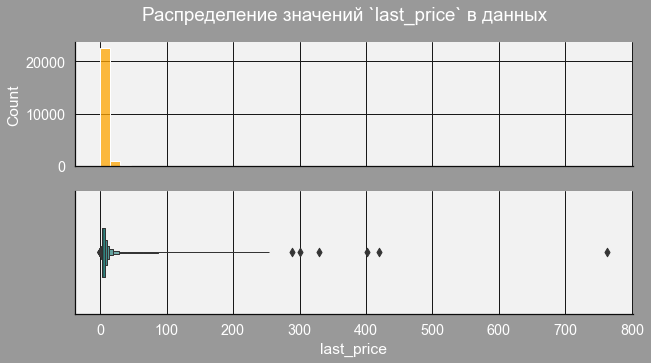

In [14]:
plot_hist_and_box_for_column(data=data, column_name='last_price', bins=50)

Из графиков видно, что есть несколько явных выбросов. Избавимся от них:

In [15]:
data = clean_outliers(data, 'last_price')

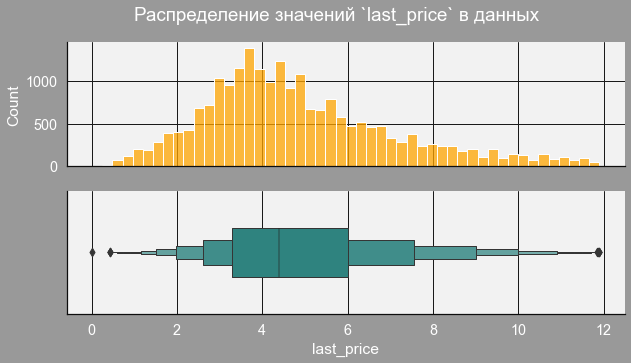

In [16]:
plot_hist_and_box_for_column(data=data, column_name='last_price', bins=50)

<a id="area"></a>

#### `total_area`, `living_area`, `kitchen_area` - устранение аномалий и выбросов

##### Посмотрим на пропущенные значения:

In [17]:
print(data['total_area'].isnull().sum())
print(data['kitchen_area'].isnull().sum())
print(data['living_area'].isnull().sum())

0
2074
1688


Попробуем запонить некоторые пропуски, если есть значение общей и жилой площади, то площадь кухни возьмем их разность. Аналогично с заполнением пропусков в жилой площади.

In [18]:
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] =  data['total_area'] - data['living_area']
data.loc[data['living_area'].isnull(), 'living_area'] =  data['total_area'] - data['kitchen_area']

In [19]:
print(data['kitchen_area'].isnull().sum())
print(data['living_area'].isnull().sum())

1317
1317


Для некоторых квартир сумма жилой площади и кухни превышает общую:

In [20]:
len(data.query('kitchen_area + living_area > total_area'))

65

##### Посмотрим на распределение значений:

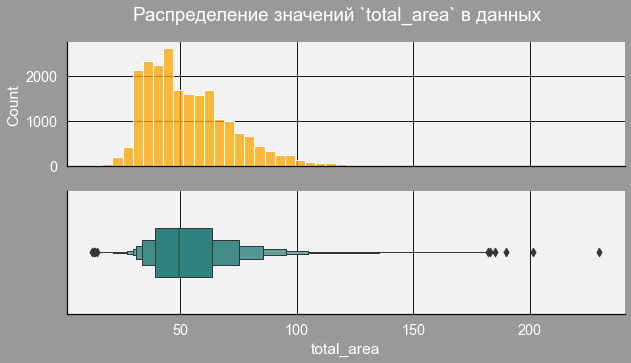

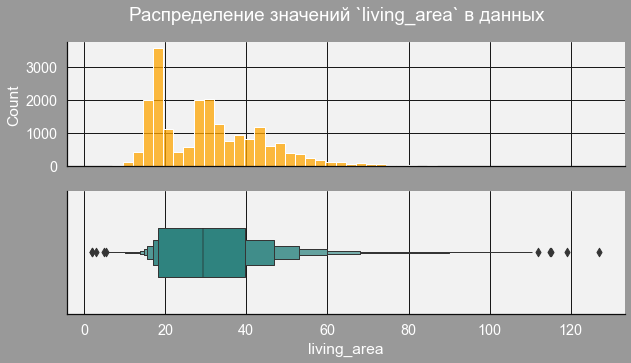

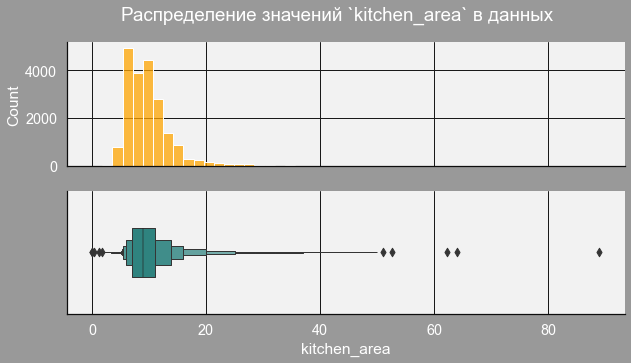

In [21]:
for col_name in ['total_area', 'living_area', 'kitchen_area']:
    plot_hist_and_box_for_column(data=data, column_name=col_name)

Удалим выбросы:

In [22]:
print(data.shape)
for col in ['total_area', 'living_area', 'kitchen_area']:
    data = clean_outliers(data, col)
print(data.shape)

(21638, 21)
(20211, 21)


In [23]:
print(data['kitchen_area'].isnull().sum())
print(data['living_area'].isnull().sum())

1293
1293


Квартиры со нерационально маленькой общей площадью тоже удалим:

In [24]:
data = data.query('total_area >= 20')

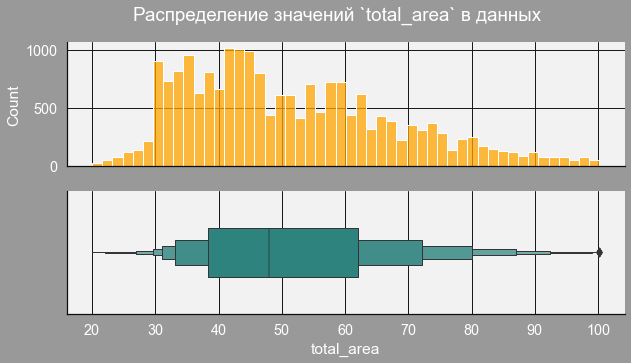

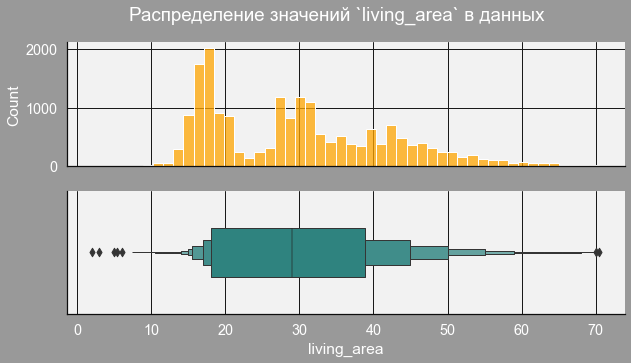

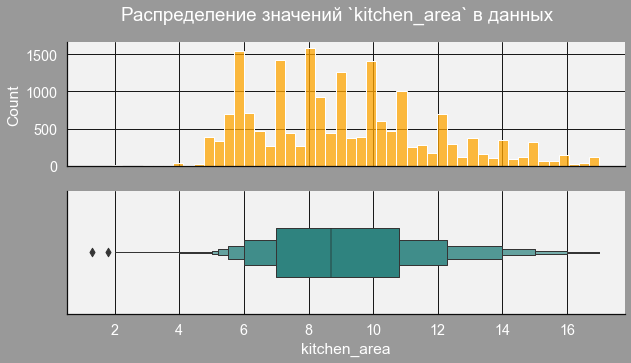

In [25]:
for col_name in ['total_area', 'living_area', 'kitchen_area']:
    plot_hist_and_box_for_column(data=data, column_name=col_name)

Добавим столбцы, где указано отношение жилой к общей и кухни к общей:

In [26]:
data.loc[:,'living_to_total'] = data.loc[:,'living_area'] / data.loc[:,'total_area']
data.loc[:,'kitchen_to_total'] = data.loc[:,'kitchen_area'] / data.loc[:,'total_area']

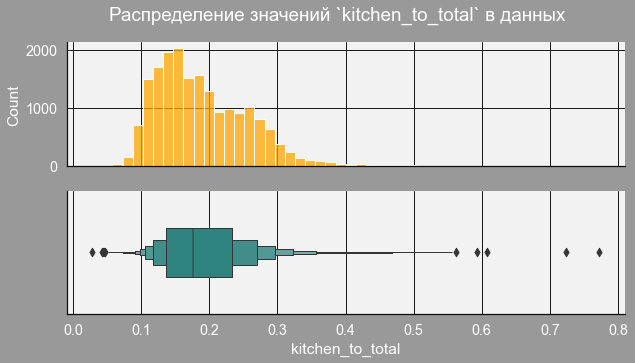

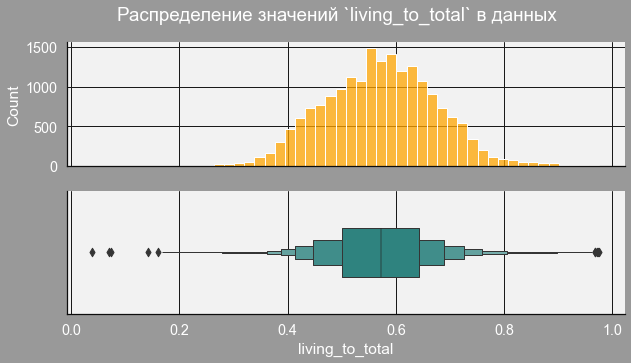

In [27]:
for col_name in ['kitchen_to_total', 'living_to_total']:
    plot_hist_and_box_for_column(data=data, column_name=col_name)

Удалим выбросы по этим признакам тоже:

In [28]:
print(data.shape)
for col in ['kitchen_to_total', 'living_to_total']:
    data = clean_outliers(data, col)
print(data.shape)

(20184, 23)
(19839, 23)


Что с пропусками и аномалиями:

In [29]:
print(data['kitchen_area'].isnull().sum())
print(data['living_area'].isnull().sum())
print(len(data.query('kitchen_area + living_area > total_area')))

1284
1284
14


Пропуски заполнить не можем, а аномальные площади удалим:

In [30]:
data = data.query('kitchen_area + living_area <= total_area')

<a id="balcony"></a>

#### `balcony` - заполнение NaN

In [31]:
data.balcony.value_counts(dropna=False)

NaN    8458
1.0    3592
2.0    3120
0.0    2982
5.0     216
4.0     120
3.0      53
Name: balcony, dtype: int64

Аномальных значений количества балконов нигде не попалось, хотя, возможно, такие строчки уже удалены, что хорошо.

В данном случае, скорее всего, не указанное количество балконов означает их отсутствие. Заполним пропуски нулями.

In [32]:
data.loc[:, 'balcony'].fillna(0, inplace=True)

<a id="floors_total"></a>

#### `floors_total` - заполнение пропущенных значений, исправление аномалий, удаление выбросов

In [33]:
data.floors_total.isnull().sum()

32

Удалим строки с пропусками, потому что заполнить мы их не можем.

In [34]:
data = data.dropna(subset=['floors_total'])

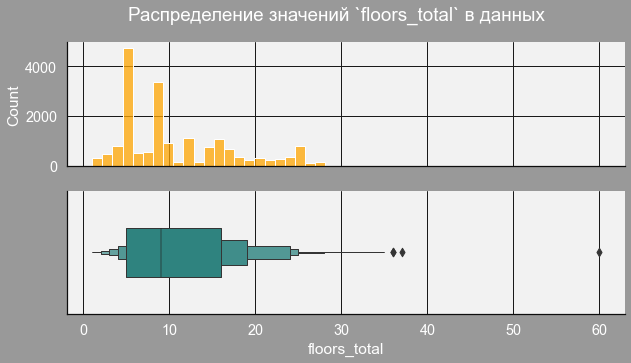

In [35]:
plot_hist_and_box_for_column(data=data, column_name='floors_total')

Распределение значений выглядит нормально, никаких миллион-этажных домов. Все равно удалим несколько выбросов (редких значений):

In [36]:
data = clean_outliers(data, 'floors_total')

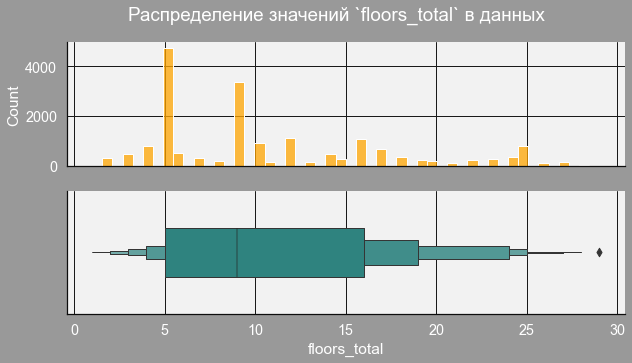

In [37]:
plot_hist_and_box_for_column(data=data, column_name='floors_total')

<a id="ceiling_height"></a>

#### `ceiling_height` - удаление аномалий и заполнение пропущенных значений

Посмотрим на пропущенные значения:

In [38]:
data.ceiling_height.isnull().sum()

6947

Пропущенные значения заполним медианой для домов одной этажности:

In [39]:
median_heights_by_floors_total = data.groupby('floors_total')['ceiling_height'].median()

In [40]:
data.loc[:, 'ceiling_height'] = data.loc[:, 'ceiling_height'].fillna(data['floors_total'].map(median_heights_by_floors_total))

In [41]:
data.ceiling_height.isnull().sum()

0

Посмотрим, какие значения принимает этот признак:

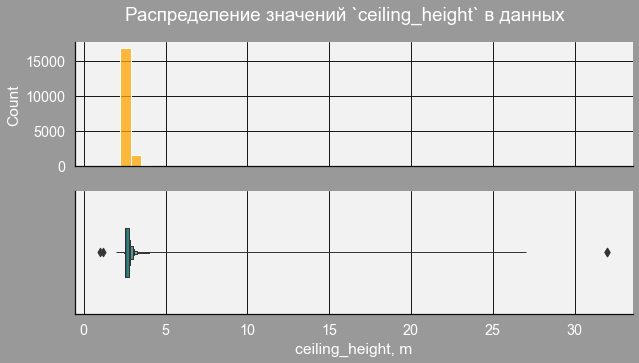

In [42]:
plot_hist_and_box_for_column(data=data, column_name='ceiling_height', label=', m')

Будем считать, что адекватные значения высоты потолков располагаются на отрезке от 2.4 до 4 метров, а остальное удалим:

In [43]:
upper = 4.0
lower = 2.4
data = data.query('@lower <= ceiling_height <= @upper')

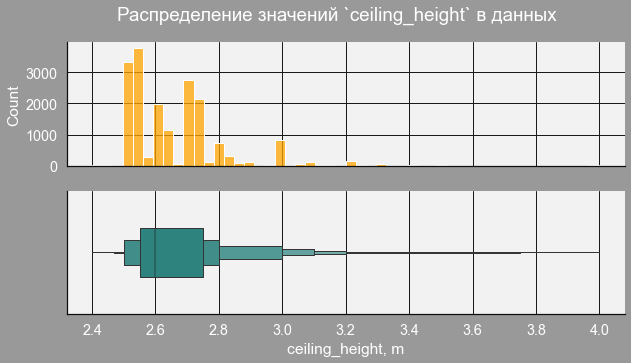

In [44]:
plot_hist_and_box_for_column(data=data, column_name='ceiling_height', label=', m')

Посмотрим, как связана этажность дома и высота потолка:

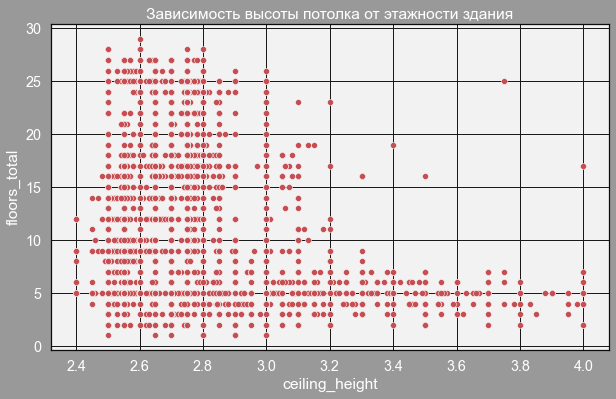

In [45]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='ceiling_height', y='floors_total', data=data, color='r')
plt.title('Зависимость высоты потолка от этажности здания')
plt.show()

Высокие потолки (более 3 метров) в основном встречаются в малоэтажных домах.  Более низкие потолки есть в домах любой этажности.

<a id="planirovka"></a>

#### `rooms`, `studio`, `open_plan` - удаление аномалий

In [46]:
data.rooms.value_counts(dropna=False).sort_index()

0     125
1    6966
2    6618
3    4199
4     510
5      25
6       1
Name: rooms, dtype: int64

После удаления выбросов выше, в этом столбце не осталось квартир, где больше 6 комнат - а они были! Еще раз убедились, что правильно удалили аномальные строчки. Думаю, шестикомнатную квартиру тоже можно удалить, раз она одна такая:

In [47]:
data = data.query('rooms != 6')

Квартиры с нулевым количеством комнат - почти все студии с площадью не больше 31 метра квадратного:

In [48]:
print(len(data.query('studio')))
print(len(data.query('rooms == 0')))
print(len(data.query('rooms == 0 and studio')))
print(data.query('rooms == 1 and studio')['total_area'].max())

91
125
85
31.0


Остальные такие квартиры так же имеют небольшую площадь:

Для них заполним число комнат единицей:

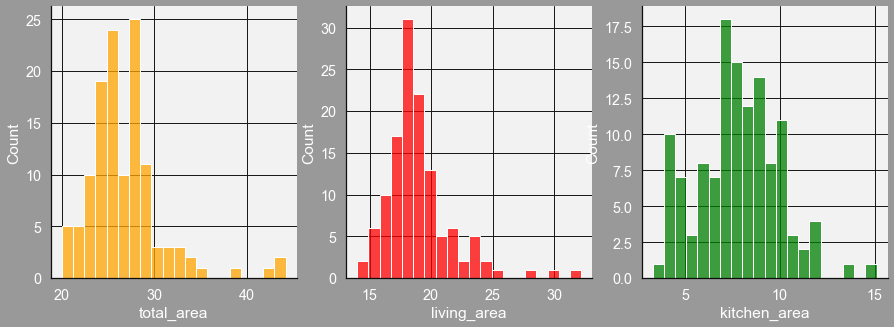

In [49]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(data=data.query('rooms == 0'), x='total_area', bins=20, color='orange', ax=ax[0])
sns.histplot(data=data.query('rooms == 0'), x='living_area', bins=20, color='red', ax=ax[1])
sns.histplot(data=data.query('rooms == 0'), x='kitchen_area', bins=20, color='green', ax=ax[2])
sns.despine()

In [50]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

In [51]:
data.studio.value_counts(dropna=False)

False    18352
True        91
Name: studio, dtype: int64

In [52]:
data.open_plan.value_counts(dropna=False)

False    18401
True        42
Name: open_plan, dtype: int64

В столбцах `studio`, `open_plan` все нормально.

<a id="floor"></a>

#### `floor`

In [53]:
data.floor.isnull().sum()

0

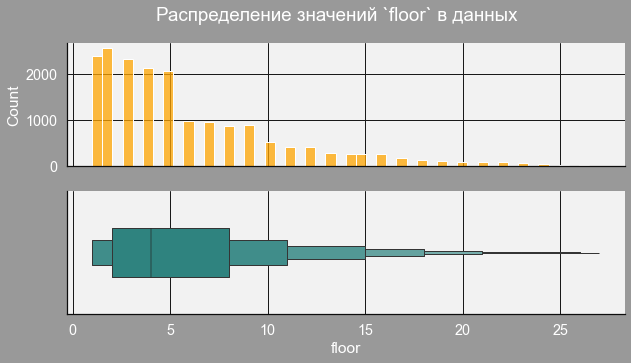

In [54]:
plot_hist_and_box_for_column(data=data, column_name='floor')

Распределение значений выглядит адекватно, сопоставимо со столбцом `'floors_total'`.

<a id="locality_name_1"></a>

#### `locality_name` - преобразование столбца

In [55]:
data.locality_name.isnull().sum()

32

Отсутствие населенного пункта в объявлении о продаже квартиры - очень странная ошибка. Удалим эти строки.

In [56]:
data = data.dropna(subset=['locality_name'], axis=0)

Преобразуем названия населенных пунктов к единому виду, а именно разобьем его на два столбца: `location_name` (название населенного пункта) и `location_type` (тип населенного пункта).

In [57]:
all_locations = data[~data['locality_name'].isnull()].locality_name.unique()
print('Всего в данных встречается {} названий различных населенных пунктов'.format(len(all_locations)))

loc_to_name_dict = {}
loc_to_type_dict = {}

for location in all_locations:
    location1 = location.strip().replace('ё','е')
    location2 = location1.split(' ')
    if len(location2) == 1:
        loctype = 'город'
        locname = location2[0]
    else:
        for letter in location1:
            if letter.isupper():
                locname = location1[location1.find(letter):]
                loctype = location1[:location1.find(letter)]
                break
    loc_to_name_dict[location] = locname
    loc_to_type_dict[location] = loctype

Всего в данных встречается 339 названий различных населенных пунктов


In [58]:
data['location_name'] = data['locality_name'].map(loc_to_name_dict)
data['location_type'] = data['locality_name'].map(loc_to_type_dict)
print('А на самом деле в данных встречается {} различных населенных пунктов'.format(data['location_name'].nunique()))

А на самом деле в данных встречается 280 различных населенных пунктов


In [59]:
data = data.drop('locality_name', axis=1)

<a id="airports_nearest"></a>

Далее идут столбцы, которые заполнялись автоматически.

#### `airports_nearest` - заполнение пропусков

In [60]:
# переведем в километры, так как в километрах удобнее воспринимать расстояния
data.loc[:, 'airports_nearest'] = data['airports_nearest'] / 1000

In [61]:
print('{:.2%}'.format(data.airports_nearest.isnull().sum() / data.shape[0]))

25.07%


Этот столбец содержит почти 25% пропусков, попробуем заполнить их средним по локации:

In [62]:
mean_airport_dist = data.pivot_table(index = 'location_name', values = 'airports_nearest', aggfunc='mean')['airports_nearest']

In [63]:
data.loc[:, 'airports_nearest'].fillna(data['location_name'].map(mean_airport_dist), inplace=True)
print('{:.2%}'.format(data.airports_nearest.isnull().sum() / data.shape[0]))

24.82%


Для очень малого количества пропусков это сработало. Эта и некоторые другие географические колонки - результат работы программы, которая автоматически проставляла значения. Очень странно, что она так плохо отработала, по-хорошему надо вернуть эти данные тому, кто их собрал, чтобы эту проблему с работой программы можно было решить. У нас такой возможности нет, поэтому с целью сохранения максимального количества данных, можно узнать расстояние от каждого населенного пункта до ближайшего аэропорта и заполнить вручную хотя бы для самых незаполненных населенных пунктов.

In [64]:
data.loc[data['airports_nearest'].isnull(), 'location_name'].value_counts(dropna=False).head(11)

Мурино             483
Кудрово            380
Всеволожск         345
Гатчина            275
Выборг             176
Новое Девяткино    128
Сертолово          125
Кириши             100
Бугры              100
Сланцы              96
Волхов              93
Name: location_name, dtype: int64

Заполним вручную для одиннадцати самых крупных. Спросим у Яндекс.Карт сколько км на маршруте от кажого из этих населенных пунктов до аэропорта Пулково:

In [65]:
airport_distances_from_yandexmaps = {'Мурино': 46.,
                                     'Кудрово': 27.,
                                     'Всеволожск':49.,
                                     'Гатчина':33.,
                                     'Выборг':160.,
                                     'Новое Девяткино':46.,
                                     'Сертолово':57.,
                                     'Кириши':160.,
                                     'Бугры':48.,
                                     'Сланцы':180.,
                                     'Волхов':140.
                                    }

In [66]:
print(data.loc[:,'airports_nearest'].isnull().sum())
data.loc[:,'airports_nearest'].fillna(data['location_name'].map(airport_distances_from_yandexmaps), inplace=True)
print(data.loc[:,'airports_nearest'].isnull().sum())

4569
2268


Примерно половину пропусков таким образом заполнили.

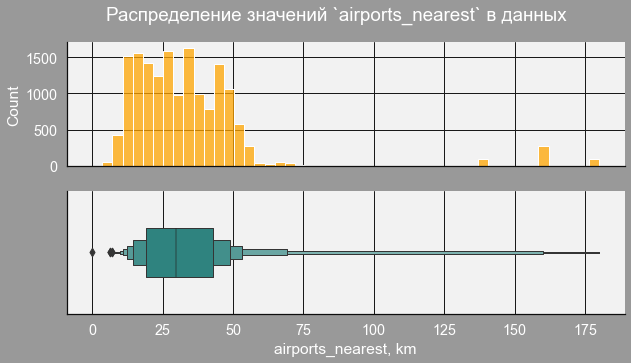

In [67]:
plot_hist_and_box_for_column(data=data, column_name='airports_nearest', label=', km')

Добавилось несколько значений-выбросов, но в данном случае это точно не аномалии.

<a id="cityCenters_nearest"></a>

#### `cityCenters_nearest`  - заполнение пропусков

In [68]:
# переведем в километры, так как в километрах удобнее воспринимать расстояния
data.loc[:, 'cityCenters_nearest'] = data.loc[:, 'cityCenters_nearest'] / 1000

In [69]:
data.cityCenters_nearest.isnull().sum()

4606

Сначала попробуем заполнить пропуски средним по локации, как делали с аэропортами:

In [70]:
mean_cityCenters_dist = data.pivot_table(index = 'location_name',
                                         values = 'cityCenters_nearest',
                                         aggfunc='mean')['cityCenters_nearest']

data.loc[:, 'cityCenters_nearest'].fillna(data['location_name'].map(mean_cityCenters_dist), inplace=True)
data.cityCenters_nearest.isnull().sum()

4569

Заполнились снова все. Поступим так же, как с расстояниями до аэропорта: запоним вручную для одиннадцати самых крупных. Спросим у Яндекс.Карт сколько км на маршруте от кажого из этих населенных пунктов до центра Санкт-Петербурга.

In [71]:
data.loc[data.cityCenters_nearest.isnull(), 'location_name'].value_counts(dropna=False).head(11)

Мурино             483
Кудрово            380
Всеволожск         345
Гатчина            275
Выборг             176
Новое Девяткино    128
Сертолово          125
Кириши             100
Бугры              100
Сланцы              96
Волхов              93
Name: location_name, dtype: int64

In [72]:
cityCenters_from_yandexmaps = {'Мурино': 25.,
                               'Кудрово': 16.,
                               'Всеволожск':25.,
                               'Гатчина':49.,
                               'Выборг':140.,
                               'Новое Девяткино':22.,
                               'Сертолово':39.,
                               'Кириши':160.,
                               'Бугры':17.,
                               'Сланцы':190.,
                               'Волхов':130.
                                    }

In [73]:
print(data.cityCenters_nearest.isnull().sum())
data.loc[:,'cityCenters_nearest'].fillna(data['location_name'].map(cityCenters_from_yandexmaps), inplace=True)
print(data.cityCenters_nearest.isnull().sum())

4569
2268


Снова почти половину пропусков таким образом заполнили.

Пропуски в этих двух колонках появились вследствие ошибки автомата, который заполнял эти колонки, он почему-то ошибся и не заполнил. Так что считаю, что запонить их таким способом можно.

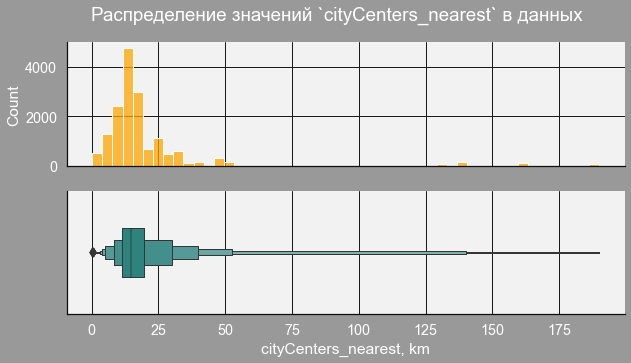

In [74]:
plot_hist_and_box_for_column(data=data, column_name='cityCenters_nearest', label=', km')

<a id="parks"></a>

#### `parks_around3000`, `parks_nearest` - замена пропущенных значений
(parks_around3000 — число парков в радиусе 3 км, parks_nearest — расстояние до ближайшего парка (м))

Во первых переведем расстояние в километры:

In [75]:
data.loc[:, 'parks_nearest'] = data.loc[:, 'parks_nearest'] / 1000

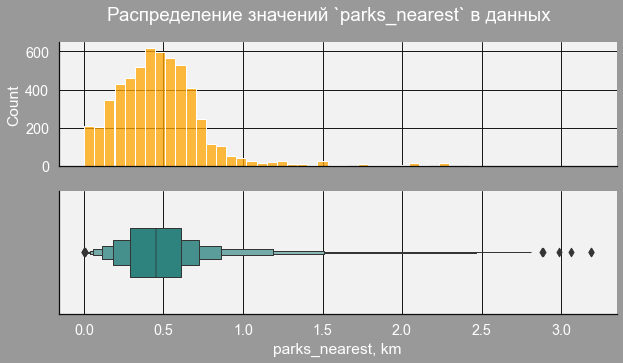

In [76]:
plot_hist_and_box_for_column(data=data,
                                 column_name='parks_nearest', label=', km')

Значения колонки `parks_nearest` аккуратно распределены, без страшных выбросов. Качественно заполнить пропуски в географических параметрах мы не можем. Следует дать рекомендации туда, откуда данные пришли.

In [77]:
print(data.parks_around3000.isnull().sum())
print(data.parks_nearest.isnull().sum())

4605
12748


In [78]:
data.parks_around3000.value_counts(dropna=True)

0.0    8146
1.0    4154
2.0    1154
3.0     352
Name: parks_around3000, dtype: int64

Аномального количества парков нет.

<a id="ponds"></a>

#### `ponds_around3000`, `ponds_nearest` - замена пропущенных значений
(`ponds_around3000` — число водоёмов в радиусе 3 км, `ponds_nearest` — расстояние до ближайшего водоёма (м))

Во первых переведем расстояние в километры:

In [79]:
data.loc[:, 'ponds_nearest'] = data.loc[:, 'ponds_nearest'] / 1000

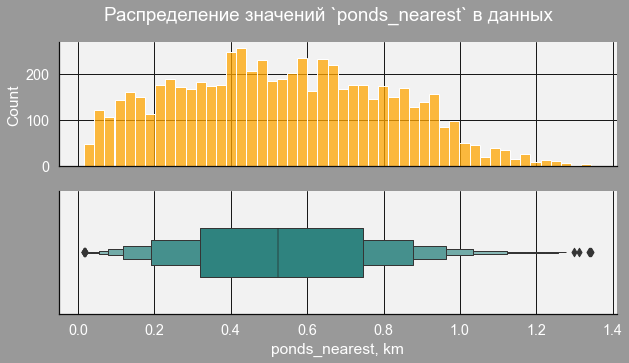

In [80]:
plot_hist_and_box_for_column(data=data, column_name='ponds_nearest', label=', km')

Значения колонки `ponds_nearest`акууратно распределены, без выбросов.

In [81]:
print(data.ponds_nearest.isnull().sum())
print(data.ponds_around3000.isnull().sum())

11927
4605


In [82]:
data.ponds_around3000.value_counts(dropna=True)

0.0    7322
1.0    4336
2.0    1331
3.0     817
Name: ponds_around3000, dtype: int64

Аномального количества прудов нет.

<a id="first_day_exposition"></a>

#### `first_day_exposition`

In [83]:
#проверим наличие пропущенных значений
data['first_day_exposition'].isnull().sum()

0

Сделаем из этого столбца временной ряд вида "дата - число опубликованных объявлений", и изобразим на графике:

In [84]:
data['first_day_exposition'].value_counts()

2018-02-01    287
2017-11-10    187
2017-10-13    106
2017-09-27     83
2018-03-26     76
             ... 
2015-01-09      1
2016-08-09      1
2015-01-11      1
2018-03-05      1
2015-09-02      1
Name: first_day_exposition, Length: 1454, dtype: int64

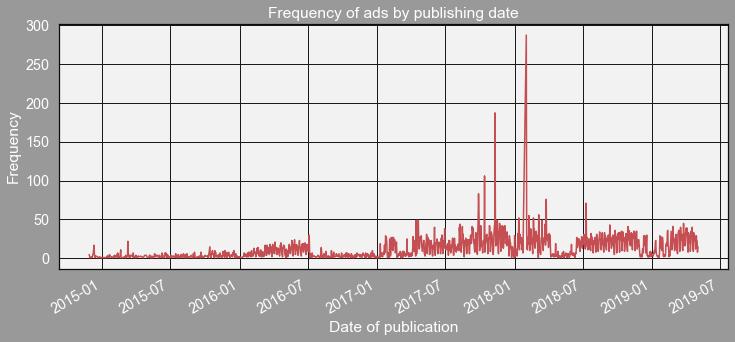

In [85]:
data['first_day_exposition'].value_counts().plot(figsize=(12,5), c='r')
plt.xlabel('Date of publication')
plt.ylabel('Frequency')
plt.title('Frequency of ads by publishing date')
plt.show()

Временной ряд не имеет каких-то выраженных закономерностей, сложно сказать про выбросы. Поговорим об этом в соответствующем разделе.

<a id="days_exposition"></a>

#### `days_exposition`

In [86]:
# изменим тип данных в стобце на целое число
data.loc[:,'days_exposition'] = data['days_exposition'].astype('int', errors='ignore')

In [87]:
#проверим наличие пропущенных значений
data.days_exposition.isnull().sum()

2278

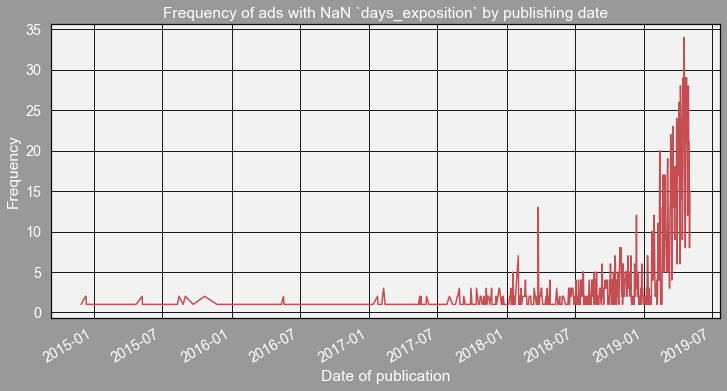

In [88]:
#посмотрим как долго висят объявления с незаполненных столбцом `days_exposition`
data.loc[data.days_exposition.isnull(), 'first_day_exposition'].value_counts().plot(figsize=(12,6), c='r')
plt.xlabel('Date of publication')
plt.ylabel('Frequency')
plt.title('Frequency of ads with NaN `days_exposition` by publishing date')
plt.show()

Вряд ли объявления висят там 5 лет, это точно аномально пропущенное значение, а вот для строк с датой публикации позже 2018 - возможно, они и вправду еще не проданы по каким-то причинам. Удалим аномальные пропуски:

In [89]:
from datetime import date
date_theshold = date(2018,1,1)
date_theshold

datetime.date(2018, 1, 1)

In [90]:
# удаляем пустые строчки с датой публикации ранее, чем 01-01-2018
data = data[~(data['days_exposition'].isnull() & (data['first_day_exposition'].dt.date < date_theshold))]
data.shape

(18183, 24)

In [91]:
data.days_exposition.isnull().sum()

2050

Пропущенных значений много достаточно. Возможно, эти объявления еще не были сняты с публикации на момент сбора данных. То есть эти строчки не подходят нам для исследования вопроса о том, как быстро и по какой цене продаются квартиры, так как мы не знаем цену, по которой это квартира в итоге будет продана. Думаю их нужно удалить:

In [92]:
data = data.dropna(subset=['days_exposition'], axis=0)
data.shape

(16133, 24)

Посмотрим на аномалии в непустых значениях:

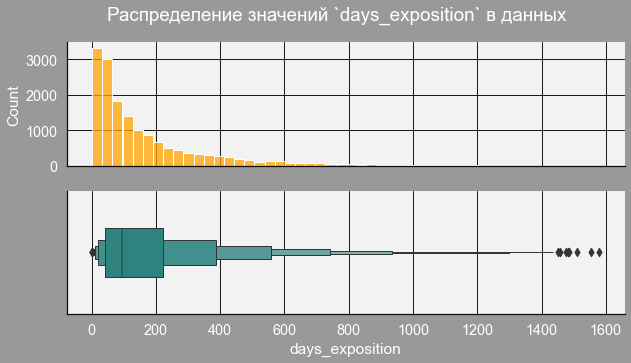

In [93]:
plot_hist_and_box_for_column(data=data, column_name='days_exposition')

In [94]:
data['days_exposition'].max()

1580.0

Аналогично пустым зачениям, оставим тут только те объявления, которые продались быстрее, чем за 2 года.

In [95]:
data = data.query('days_exposition < 2*365')

In [96]:
data.shape

(15612, 24)

Качественно разобрались с пропусками и аномальными значениями! Теперь можно перейти к анализу того, что имеем.

<a id="datatypes"></a>

### *1.3 Изменение типов данных*

В самом начале уже определили, что некоторые колонки имеют не тот тип данных, который в них ожидается.

In [97]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
living_to_total                float64
kitchen_to_total               float64
location_name                   object
location_type                   object
dtype: object

In [98]:
data.loc[:,'floors_total'] = data.loc[:,'floors_total'].astype('int')
data.loc[:,'balcony'] = data.loc[:,'balcony'].astype('int')
data.loc[:,'parks_around3000'] = data.loc[:,'parks_around3000'].astype('int', errors='ignore')
data.loc[:,'ponds_around3000'] = data.loc[:,'ponds_around3000'].astype('int', errors='ignore')
data.loc[:,'days_exposition'] = data.loc[:,'days_exposition'].astype('int')
data.loc[:,'location_type'] = data.loc[:,'location_type'].astype('category')

In [99]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15612 entries, 1 to 23695
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15612 non-null  int64         
 1   last_price            15612 non-null  float64       
 2   total_area            15612 non-null  float64       
 3   first_day_exposition  15612 non-null  datetime64[ns]
 4   rooms                 15612 non-null  int64         
 5   ceiling_height        15612 non-null  float64       
 6   floors_total          15612 non-null  int64         
 7   living_area           15612 non-null  float64       
 8   floor                 15612 non-null  int64         
 9   studio                15612 non-null  bool          
 10  open_plan             15612 non-null  bool          
 11  kitchen_area          15612 non-null  float64       
 12  balcony               15612 non-null  int64         
 13  airports_nearest

<a id="add_data"></a>

### *1.4 Добавление новых признаков*

Добавим в таблицу новые признаки из существующих:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;

In [100]:
def make_floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        floor_type = 'первый'
    elif floor == floors_total:
        floor_type = 'последний'
    else:
        floor_type = 'другой'
    return(floor_type)

In [101]:
data.loc[:,'cost_per_m2'] = data.loc[:,'last_price'] / data.loc[:,'total_area'] * 1000000
data.loc[:,'weekday'] =  data.loc[:,'first_day_exposition'].dt.weekday
data.loc[:,'month'] =  data.loc[:,'first_day_exposition'].dt.month
data.loc[:,'year'] =  data.loc[:,'first_day_exposition'].dt.year

data.loc[:,'floor_type'] = data.apply(make_floor_type, axis=1).astype('category')

In [102]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15612 entries, 1 to 23695
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15612 non-null  int64         
 1   last_price            15612 non-null  float64       
 2   total_area            15612 non-null  float64       
 3   first_day_exposition  15612 non-null  datetime64[ns]
 4   rooms                 15612 non-null  int64         
 5   ceiling_height        15612 non-null  float64       
 6   floors_total          15612 non-null  int64         
 7   living_area           15612 non-null  float64       
 8   floor                 15612 non-null  int64         
 9   studio                15612 non-null  bool          
 10  open_plan             15612 non-null  bool          
 11  kitchen_area          15612 non-null  float64       
 12  balcony               15612 non-null  int64         
 13  airports_nearest

In [103]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,days_exposition,living_to_total,kitchen_to_total,location_name,location_type,cost_per_m2,weekday,month,year,floor_type
1,7,3.350,40.40,2018-12-04,1,2.70,11,18.60,1,False,...,81,0.460396,0.272277,Шушары,поселок,82920.792079,1,12,2018,первый
2,10,5.196,56.00,2015-08-20,2,2.55,5,34.30,4,False,...,558,0.612500,0.148214,Санкт-Петербург,город,92785.714286,3,8,2015,другой
5,10,2.890,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,55,0.473684,0.299342,Янино-1,городской поселок,95065.789474,0,9,2018,другой
8,20,2.900,33.16,2018-05-23,1,2.70,27,15.43,26,False,...,189,0.465320,0.265682,Мурино,поселок,87454.764777,2,5,2018,другой
9,18,5.400,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,289,0.714754,0.106557,Санкт-Петербург,город,88524.590164,6,2,2017,другой


<a id="eda"></a>

### *1.5 Проведение исследовательского анализа данных*

<a id="step_1"></a>

### Изучим следующие параметры: площадь, цена, число комнат, высота потолков.

Выше мы уже строили гистограммы значений этих столбцов, потому что это помогло удалить аномалии, выбросы и заполнить пропущенные значения. Посмотрим на эти гистограммы после завершенной предварительной обработки данных:

<a id="area"></a>

#### `площадь`

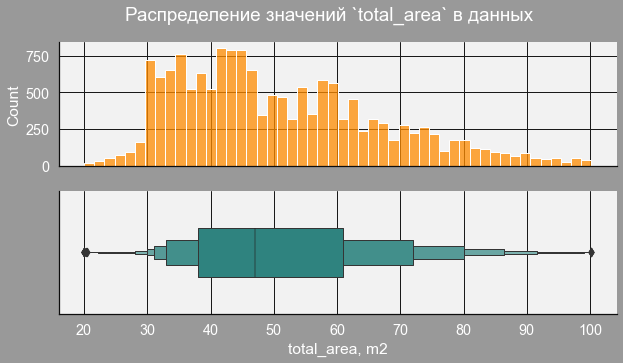

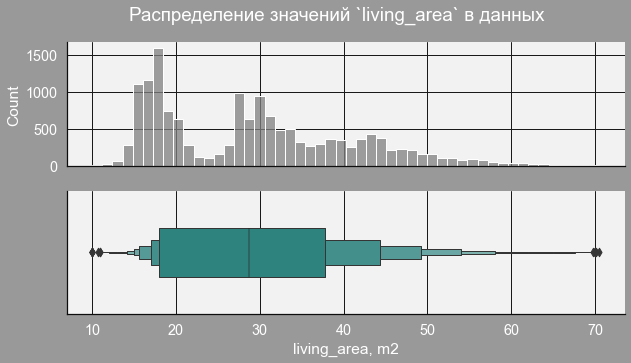

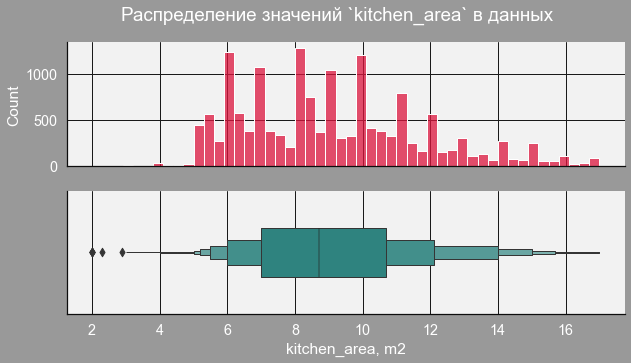

In [104]:
for i, col_name in enumerate(['total_area', 'living_area', 'kitchen_area']):
    plot_hist_and_box_for_column(data=data, column_name=col_name, label=', m2', color=colors[i])

Большинство квартир имеют площадь от 40 до 60 метров, однако встречаются и очень маленькие (20-30 м2), и достаточно большие (100 м2) квартиры.

Так же все еще присутствуют квартиры с площадью кухни 2 $м^2$.

<a id="last_price"></a>

#### `цена`

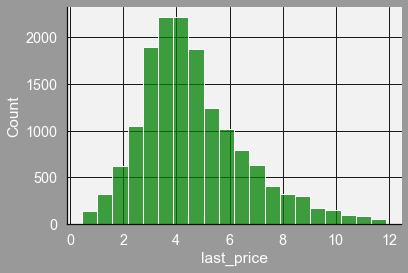

In [105]:
sns.histplot(data=data, x='last_price', bins=20, color='green')
sns.despine()

Самая дорогая квартира стоит около 12 млн.руб. Но большинство цен на квартиры находятся в диапазоне 3-6 млн.руб.

#### `число комнат`

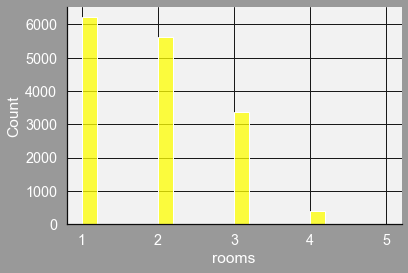

In [106]:
sns.histplot(data=data, x='rooms', bins=20, color='yellow')
sns.despine()

Однушек больше всех, но встречаются и пятерки. А все странные 19-тикомнатные квартиры мы выкинули!

#### `высота потолков`

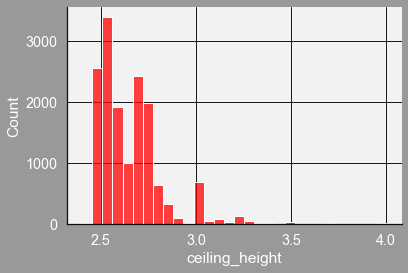

In [107]:
sns.histplot(data=data, x='ceiling_height', bins=30, color='red')
sns.despine()

Большинство квартир имеет высоту 2.6-2.7 м. Но встречаются и высокие потолки, как в московских сталинках!

<a id="step_2"></a>

### Изучим время продажи квартиры

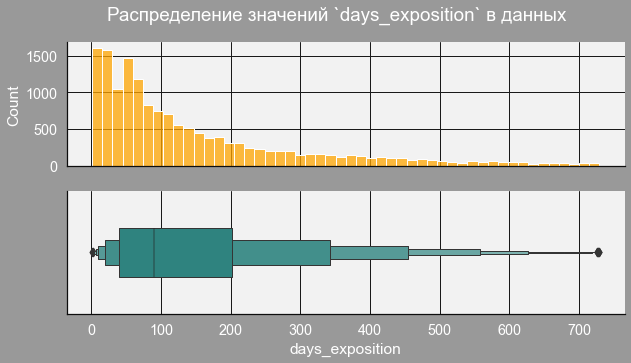

In [108]:
plot_hist_and_box_for_column(data=data, column_name='days_exposition')

In [109]:
data.days_exposition.describe()

count    15612.000000
mean       147.751473
std        153.335189
min          1.000000
25%         40.000000
50%         90.000000
75%        202.000000
max        729.000000
Name: days_exposition, dtype: float64

Большая часть квартир продается менее, чем за 202 дня. Думаю, в жизни они так и бывает, если не сильно заниматься продажей. В среднем на это уходит 148 дней, но медианный срок - 90 дней. Все из-за наличия более трех тысяч квартир, которые продаются больше года! Так же есть супер-быстрые продажи (положим, менее недели) - 721 квартира были проданы именно так быстро.

In [110]:
# сколько долгих продаж
len(data.query('days_exposition > 220'))

3529

In [111]:
# сколько супер-быстрых продаж
len(data.query('days_exposition < 8'))

721

<a id="step_3"></a>

### Какие факторы больше всего влияют на стоимость квартиры?
* Изучим, зависит ли цена от площади, числа комнат, удалённости от центра.
* Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.
* Также посмотрим зависимость от даты размещения: дня недели, месяца и года.

#### Цена от площади

In [112]:
data.loc[:, 'cost_per_m2'] = data['cost_per_m2'] / 1000

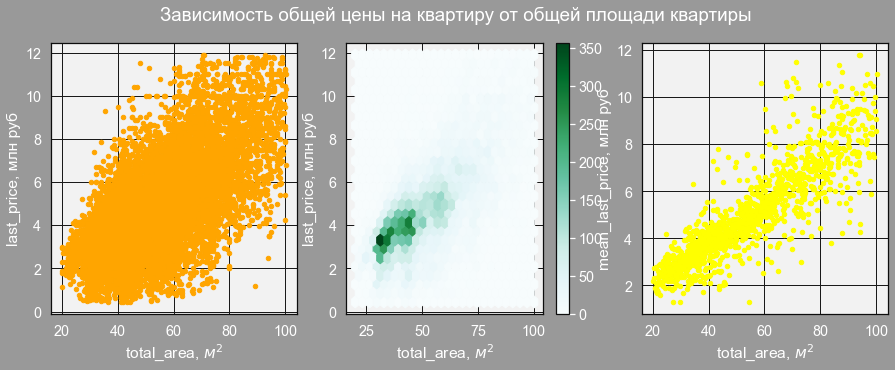

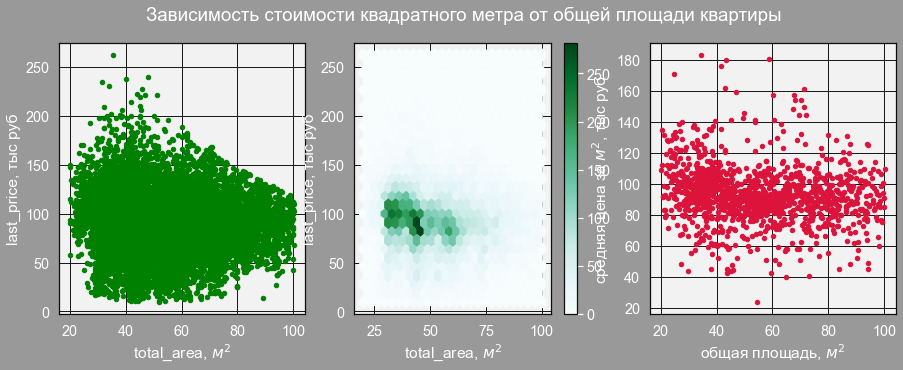

In [113]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
data.plot(x='total_area', y='last_price', kind='scatter', color='orange', ax=ax[0])
ax[0].set_ylabel('last_price, млн руб')
ax[0].set_xlabel('total_area, $м^2$')
data.plot(x='total_area', y='last_price', kind='hexbin', gridsize=25, sharex=False, grid=True, ax=ax[1])
ax[1].set_ylabel('last_price, млн руб')
ax[1].set_xlabel('total_area, $м^2$')
data.pivot_table(index='total_area',
                 values='last_price',
                 aggfunc='mean').reset_index().plot(x='total_area',
                                                    y='last_price',
                                                    kind='scatter',
                                                    color='yellow',
                                                    ax=ax[2])
ax[2].set_ylabel('mean_last_price, млн руб')
ax[2].set_xlabel('total_area, $м^2$')
plt.suptitle('Зависимость общей цены на квартиру от общей площади квартиры')
plt.show()



fig, ax = plt.subplots(1,3, figsize=(15,5))
data.plot(x='total_area', y='cost_per_m2', kind='scatter', color='green', ax=ax[0])
ax[0].set_ylabel('last_price, тыс руб')
ax[0].set_xlabel('total_area, $м^2$')
data.plot(x='total_area', y='cost_per_m2', kind='hexbin', gridsize=25, sharex=False, grid=True, ax=ax[1])
ax[1].set_ylabel('last_price, тыс руб')
ax[1].set_xlabel('total_area, $м^2$')
data.pivot_table(index='total_area',
                 values='cost_per_m2',
                 aggfunc='mean').reset_index().plot(x='total_area',
                                                    y='cost_per_m2',
                                                    kind='scatter',
                                                    color=colors[2],
                                                    ax=ax[2])
ax[2].set_ylabel('средняя цена за $м^2$, тыс руб')
ax[2].set_xlabel('общая площадь, $м^2$')
plt.suptitle('Зависимость стоимости квадратного метра от общей площади квартиры')
plt.show()

In [114]:
data['total_area'].corr(data['last_price'])

0.6853408507325123

In [115]:
data['total_area'].corr(data['cost_per_m2'])

-0.09005368643199954

Облако точек вытянуто вдоль диагонали снизу вверх, что говорит о том, что с увеличеснием площади, увеличивается цена. Положительный коэффициент корреляции равный 0.69 это подтвержает. При этом цена за метр немного уменьшается с увеличением общей площади.

#### Цена от числа комнат

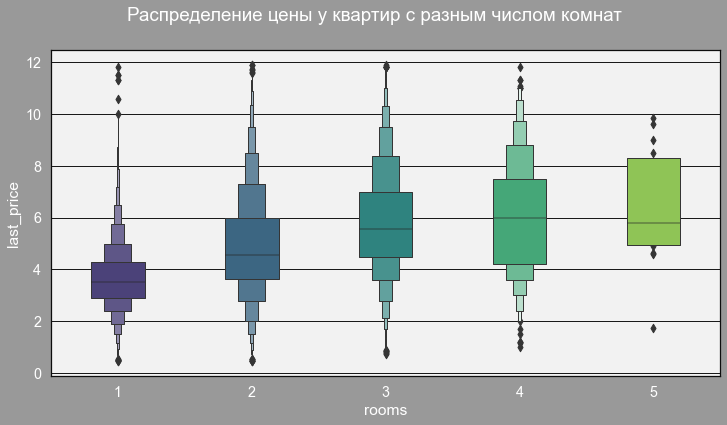

In [116]:
plt.figure(figsize=(12,6))
sns.boxenplot(x='rooms',
              y='last_price',
              data=data,
              palette='viridis',
              width = 0.4,
             )
plt.suptitle('Распределение цены у квартир с разным числом комнат')
plt.show()

In [117]:
data['rooms'].corr(data['last_price'])

0.42900114172880416

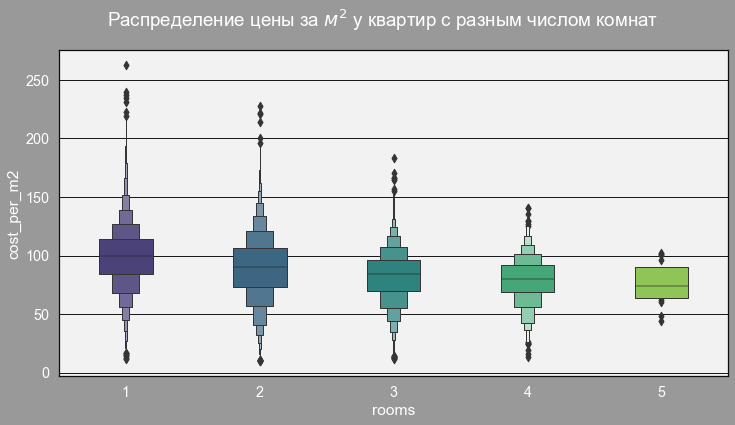

In [118]:
plt.figure(figsize=(12,6))
sns.boxenplot(x='rooms',
              y='cost_per_m2',
              data=data,
              palette='viridis',
              width = 0.4,
             )
plt.suptitle('Распределение цены за $м^2$ у квартир с разным числом комнат')
plt.show()

In [119]:
data['rooms'].corr(data['cost_per_m2'])

-0.23760398742528172

Чем больше комнат, тем больше медианная цена всей квартиры и тем меньше стоимость квадратного метра.

#### Цена от удаленности от центра

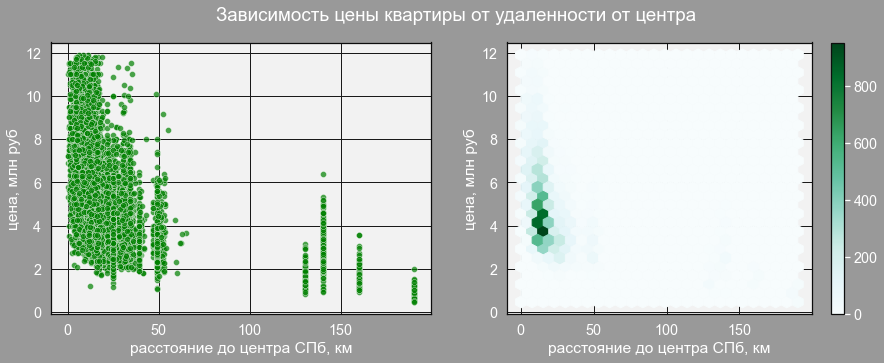

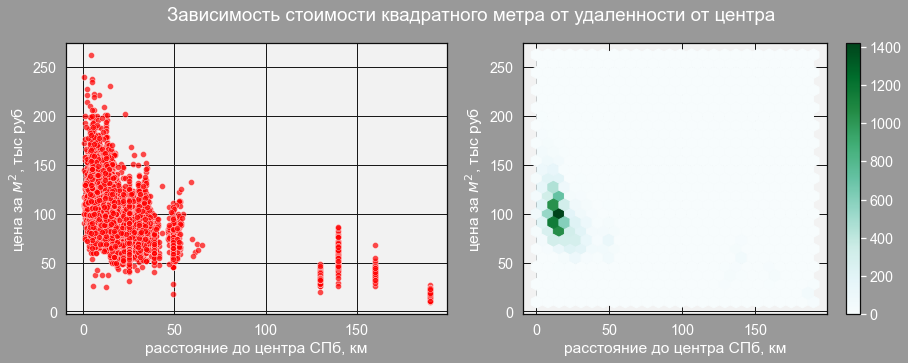

In [120]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(x='cityCenters_nearest', y='last_price', data=data, c=['green'], alpha=0.7, ax=ax[0])
ax[0].set_ylabel('цена, млн руб')
ax[0].set_xlabel('расстояние до центра СПб, км')

data.plot(x='cityCenters_nearest', y='last_price', kind='hexbin', gridsize=25, sharex=False, grid=True, ax=ax[1])
ax[1].set_ylabel('цена, млн руб')
ax[1].set_xlabel('расстояние до центра СПб, км')
plt.suptitle('Зависимость цены квартиры от удаленности от центра')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(x='cityCenters_nearest', y='cost_per_m2', data=data, c=['red'], alpha=0.7,  ax=ax[0])
ax[0].set_ylabel('цена за $м^2$, тыс руб')
ax[0].set_xlabel('расстояние до центра СПб, км')

data.plot(x='cityCenters_nearest', y='cost_per_m2', kind='hexbin', gridsize=25, sharex=False, grid=True, ax=ax[1])
ax[1].set_ylabel('цена за $м^2$, тыс руб')
ax[1].set_xlabel('расстояние до центра СПб, км')
plt.suptitle('Зависимость стоимости квадратного метра от удаленности от центра')
plt.show()

In [121]:
data['cityCenters_nearest'].describe()

count    13851.000000
mean        20.101628
std         23.778373
min          0.208000
25%         11.487000
50%         14.687000
75%         19.487000
max        190.000000
Name: cityCenters_nearest, dtype: float64

In [122]:
data['cityCenters_nearest'].corr(data['last_price'])

-0.37951210174743316

In [123]:
data['cityCenters_nearest'].corr(data['cost_per_m2'])

-0.519300386496434

Большая часть квартир располагается до 20 км от центра Санкт-Петербурга. Остальные расстояния представлены не многочисленно, поэтому сложно достоверно сказать о зависимости цены от удаленности. Интуитивно кажется, что чем дальше, чем дешевле, это подтверждают коэффициенты корреляции.

#### Цена от этажа

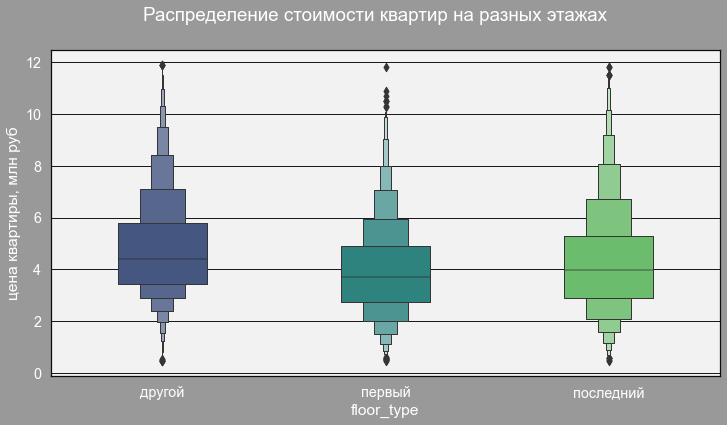

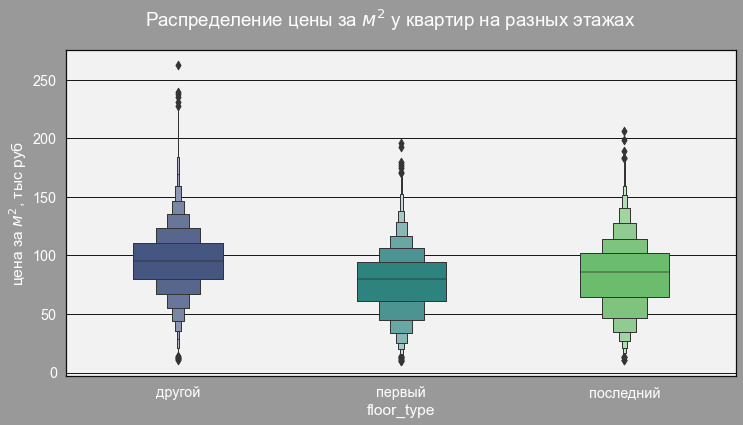

In [124]:
plt.figure(figsize=(12,6))
sns.boxenplot(x='floor_type',
              y='last_price',
              data=data,
              palette='viridis',
              width = 0.4,
             )
plt.ylabel('цена квартиры, млн руб')
plt.suptitle('Распределение стоимости квартир на разных этажах')
plt.show()

plt.figure(figsize=(12,6))
sns.boxenplot(x='floor_type',
              y='cost_per_m2',
              data=data,
              palette='viridis',
              width = 0.4,
             )
plt.ylabel('цена за $м^2$, тыс руб')
plt.suptitle('Распределение цены за $м^2$ у квартир на разных этажах')
plt.show()

In [125]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median')

,last_price
floor_type,
другой,4.412094
первый,3.700000
последний,3.990000


In [126]:
data.pivot_table(index='floor_type', values='cost_per_m2', aggfunc='median')

,cost_per_m2
floor_type,
другой,95.348837
первый,79.808244
последний,85.483871


Медианная цена ниже для первого/последнего этажа, чем для прочих. Разница, кажется, не очень большая, можно было бы по критерию Стьюдента сравнить среднее выборок.

#### Цена от даты размещения: дня недели, месяца и года

Нарисуем временной ряд со значениями медианной цены квартир, опубликованных в этот день (цена у нас в миллионах для удобства):

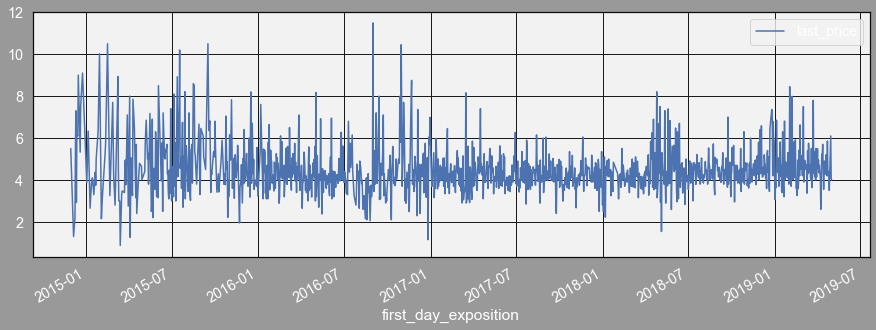

In [127]:
data.pivot_table(index='first_day_exposition', values='last_price', aggfunc='median').plot(figsize=(15,5))
plt.show()

Глазами не видно ни сезонности, ни тренда.

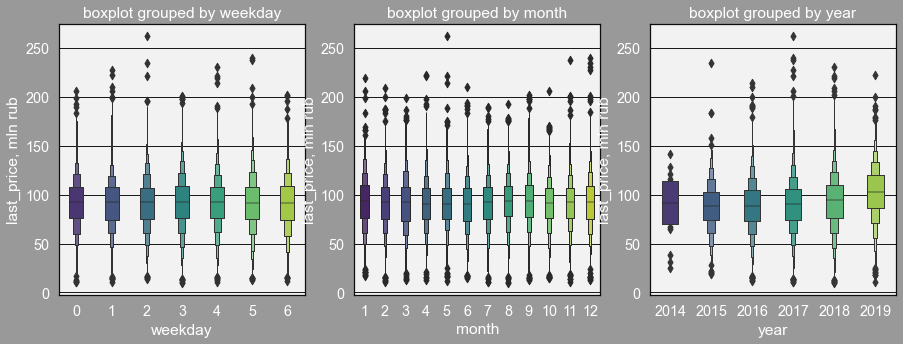

In [128]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, col_name in enumerate(['weekday','month','year']):
    #data.boxplot('last_price', by=col_name, ax=ax[i])
    sns.boxenplot(x=col_name, y='cost_per_m2', data=data,
                  palette='viridis', width = 0.4, ax=ax[i])
    ax[i].set_title('boxplot grouped by '+col_name)
    ax[i].set_ylabel('last_price, mln rub')
plt.suptitle('')
plt.show()

В среднем цена не зависит от дня недели, месяца или года, в который была сделана публикация.

<a id="step_4"></a>

### Изучим 10 населённых пунктов с наибольшим числом объявлений.
* Посчитаем среднюю цену квадратного метра в этих населённых пунктах.
* Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [129]:
# самые популярные населённые пункты
popular_locations = data.location_name.value_counts().head(10)
popular_locations

Санкт-Петербург    10078
Мурино               436
Шушары               345
Кудрово              340
Всеволожск           281
Колпино              277
Парголово            238
Пушкин               230
Гатчина              226
Петергоф             154
Name: location_name, dtype: int64

In [130]:
# срез данных для самых популярных населённых пунктов
data_popular_locations = data.query('location_name in @popular_locations.index')
print('Популярные населенные пункты составляют {:.1%} от всех объявлений в отфильтрованных данных'.format(len(data_popular_locations)/len(data)))

Популярные населенные пункты составляют 80.7% от всех объявлений в отфильтрованных данных


In [131]:
# считаем среднюю цену квадратного метра в самых популярных населённых пунктах
data_popular_cost_per_meter = data_popular_locations.pivot_table(index='location_name', values='cost_per_m2', aggfunc='mean').sort_values('cost_per_m2', ascending=False)
data_popular_cost_per_meter

,cost_per_m2
location_name,
Санкт-Петербург,104.057577
Пушкин,98.651036
Кудрово,95.332291
Парголово,89.958824
Мурино,85.842283
Петергоф,82.309421
Шушары,77.643453
Колпино,74.695677
Гатчина,67.882685


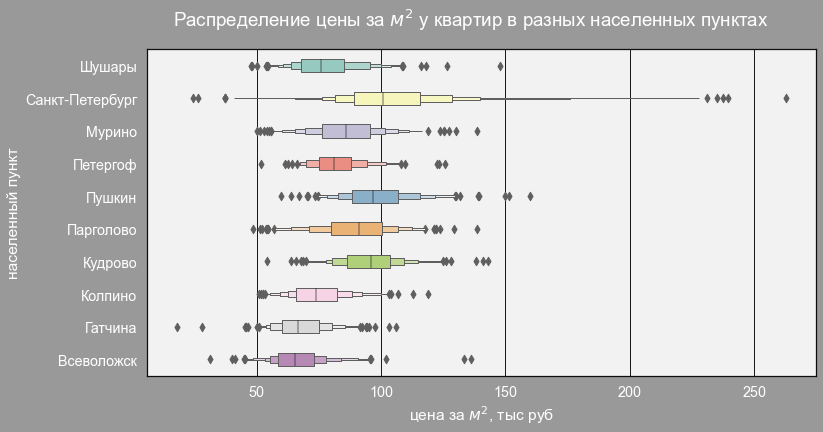

In [132]:
plt.figure(figsize=(12,6))
sns.boxenplot(y='location_name',
              x='cost_per_m2',
              data=data_popular_locations,
              palette='Set3',
              width = 0.4,
             )
plt.xlabel('цена за $м^2$, тыс руб')
plt.ylabel('населенный пункт')
plt.suptitle('Распределение цены за $м^2$ у квартир в разных населенных пунктах')
plt.show()

In [133]:
# Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья
print('Самая высокая цена за кв.метр в городе {} и она составляет {:.2f} руб./кв.м'.format(data_popular_cost_per_meter.idxmax().values[0],
                                                                                           data_popular_cost_per_meter.max().values[0]))
print('Самая низкая цена за кв.метр в городе {} и она составляет {:.2f} руб./кв.м'.format(data_popular_cost_per_meter.idxmin().values[0],
                                                                                           data_popular_cost_per_meter.min().values[0]))

Самая высокая цена за кв.метр в городе Санкт-Петербург и она составляет 104.06 руб./кв.м
Самая низкая цена за кв.метр в городе Всеволожск и она составляет 66.70 руб./кв.м


<a id="step_5"></a>

### Выделим квартиры в центре СанктПетербурга

In [134]:
# отделяем данные по Санкт-Петербургу
spb_data = data.query('location_name == "Санкт-Петербург"')
# расстояния у нас уже в километрах, округлим их до целых
spb_data.loc[:,'cityCenters_nearest'] = spb_data.loc[:,'cityCenters_nearest'].round()

Построим график для средних цен на каждом расстоянии:

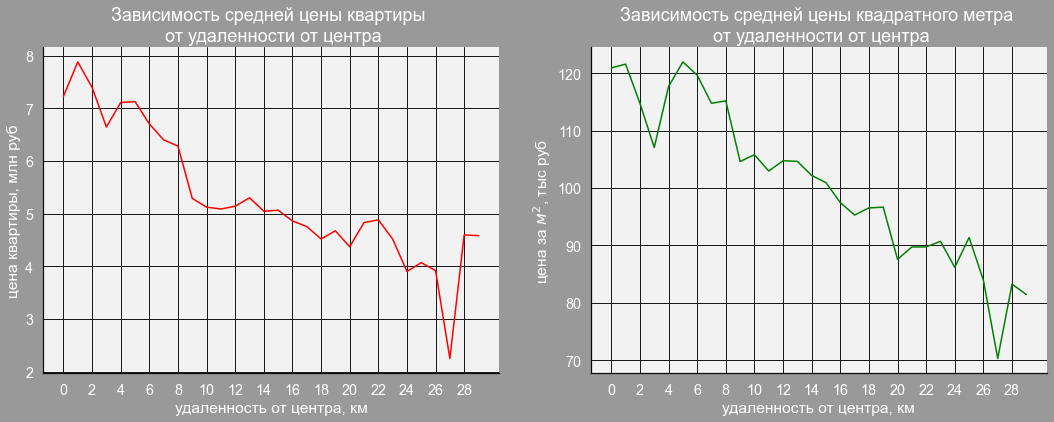

In [135]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.lineplot(x='cityCenters_nearest', y='last_price',
             data=spb_data.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='mean'),
             color='red', ax=ax[0])
ax[0].set_title('Зависимость средней цены квартиры \n от удаленности от центра', fontsize = 18)
ax[0].set_ylabel('цена квартиры, млн руб')
ax[0].set_xlabel('удаленность от центра, км')
ax[0].set_xticks(np.arange(0,30,2))


sns.lineplot(x='cityCenters_nearest', y='cost_per_m2',
             data=spb_data.pivot_table(index='cityCenters_nearest', values='cost_per_m2', aggfunc='mean'),
             color='green', ax=ax[1])
ax[1].set_title('Зависимость средней цены квадратного метра \n от удаленности от центра', fontsize = 18)
ax[1].set_ylabel('цена за $м^2$, тыс руб')
ax[1].set_xlabel('удаленность от центра, км')
ax[1].set_xticks(np.arange(0,30,2))

sns.despine()

Центральная зона, кажется, имеет радиус  около 8 км.

<a id="step_6"></a>

### Проанализируем квартиры в центре
* Изучите следующие параметры: площадь, цена, число комнат, высота потолков
* Выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).
* Отличаются ли они от общих выводов по всему городу?

In [136]:
data_center = spb_data.query('cityCenters_nearest <= 8')

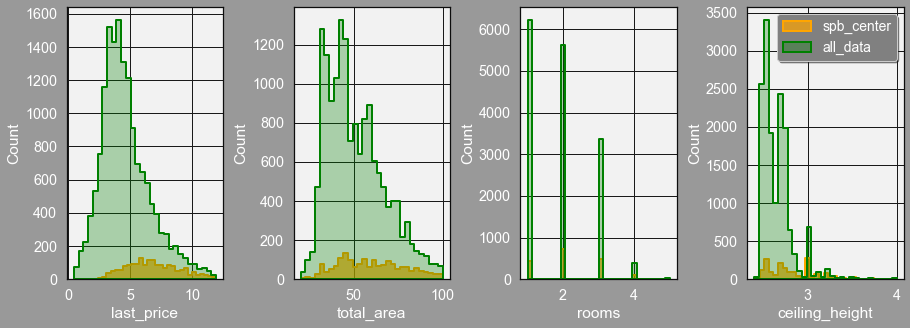

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for i, column_name in enumerate(['last_price', 'total_area', 'rooms', 'ceiling_height']):
    sns.histplot(data=data_center,
                 x=column_name,
                 element='step', bins=30,
                 linewidth=2, alpha=0.7,
                 color='orange',
                 label='spb_center',
                 ax=ax[i])
    sns.histplot(data=data,
                 x=column_name,
                 element='step', bins=30,
                 linewidth=2, alpha=0.3,
                 color='green',
                 label='all_data',
                 ax=ax[i])
    ax[i].set_xlabel(column_name)

plt.legend(shadow = True, fontsize = 14, facecolor='0.5')
plt.subplots_adjust(wspace=0.45)
plt.show()

По этим гистограммам видно, что средняя цена на квартиру в центре выше. Про остальные параметры нельзя сказать, что они отличаются.

Посмотрим, как число комнат, этаж, удалённость от центра, дата размещения объявления влияют на цену за квадратный метр, а так же на общую цену.

In [138]:
def plot_two_grouped_boxplots(data, col_name_1, col_name_2, by, title=None):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for i, col_name in enumerate([col_name_1, col_name_2]):
        sns.boxenplot(x=by, y=col_name, data=data,
                  palette='viridis', width = 0.4, ax=ax[i])
        ax[i].set_ylabel(col_name)
    plt.suptitle(title)
    plt.show()

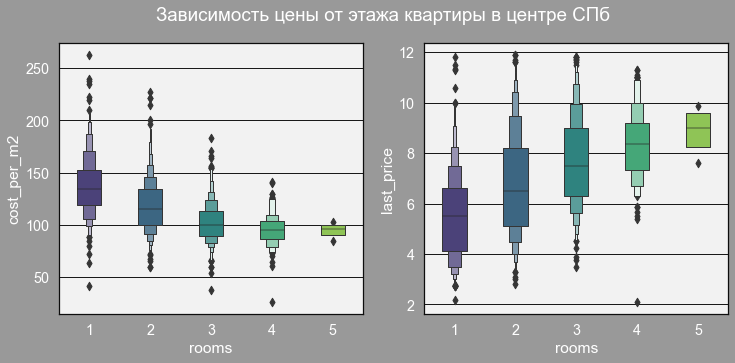

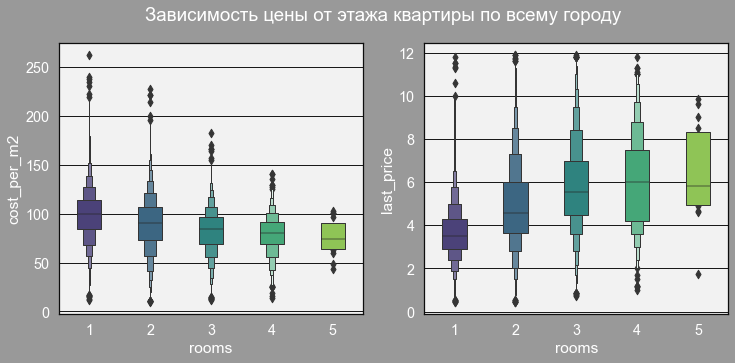

In [139]:
col_name_1 = 'cost_per_m2'
col_name_2 = 'last_price'
by = 'rooms'
plot_two_grouped_boxplots(data_center, col_name_1, col_name_2, by,
                         title='Зависимость цены от этажа квартиры в центре СПб')
plot_two_grouped_boxplots(data, col_name_1, col_name_2, by,
                         title='Зависимость цены от этажа квартиры по всему городу')

Зависимости для центра Питера и всей области сходны. Медианная цена за квадратный метр падает с увеличением числа комнат. Общая цена при этом, конечно, растет.

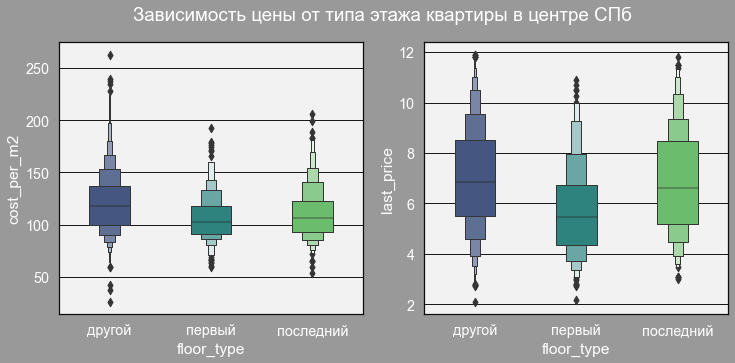

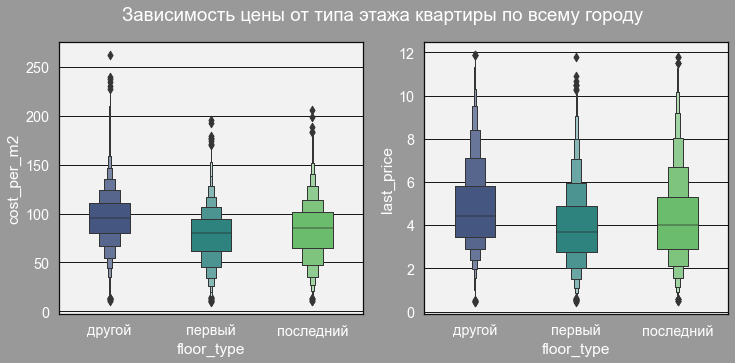

In [140]:
col_name_1='cost_per_m2'
col_name_2='last_price'
by='floor_type'
plot_two_grouped_boxplots(data_center, col_name_1, col_name_2, by,
                         title='Зависимость цены от типа этажа квартиры в центре СПб')
plot_two_grouped_boxplots(data, col_name_1, col_name_2, by,
                         title='Зависимость цены от типа этажа квартиры по всему городу')

И цена за квадратный метр, и общая стоимость квартиры ниже для квартир на первом и последнем этажах.

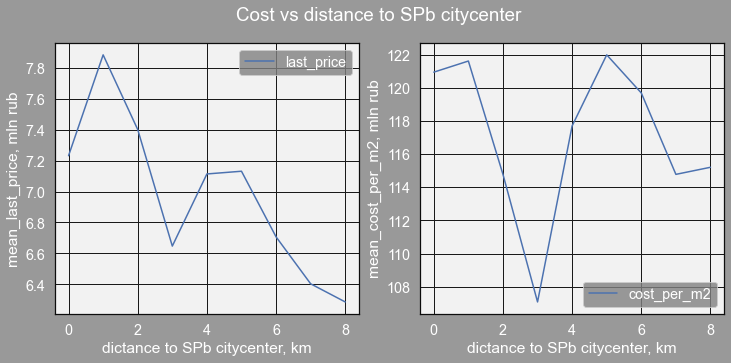

In [141]:
# сделаем сводные таблицы, где значения - средние цены в зависимости от удаленности от центра
data_center_mean_price = data_center.pivot_table(index='cityCenters_nearest',
                                                 values='last_price',
                                                 aggfunc='mean')
data_center_mean_сost_per_m2 = data_center.pivot_table(index='cityCenters_nearest',
                                                       values='cost_per_m2',
                                                       aggfunc='mean')

# изобразим полученные значения на графике
fig, ax = plt.subplots(1,2, figsize=(12,5))
data_center_mean_price.plot(ax=ax[0])
data_center_mean_сost_per_m2.plot(ax=ax[1])
ax[0].set_ylabel('mean_last_price, mln rub')
ax[1].set_ylabel('mean_cost_per_m2, mln rub')
ax[0].set_xlabel('dictance to SPb citycenter, km')
ax[1].set_xlabel('dictance to SPb citycenter, km')
ax[0].legend(facecolor='0.5')
ax[1].legend(facecolor='0.5')
plt.suptitle('Cost vs distance to SPb citycenter')
plt.show()

In [142]:
print(data_center['cityCenters_nearest'].corr(data_center['cost_per_m2']))
print(data_center['cityCenters_nearest'].corr(data_center['last_price']))

0.0014809239765670233
-0.16832144003414853


Общая цена, кажется, падает с увеличением расстояния от центра, а вот с ценой за метр квадратный по графику сложно дать однозначный ответ. Однако коэффициент корреляции для расстояния от центра и цены за квадратный метр говорит о том, что линейной зависимости почти нет.

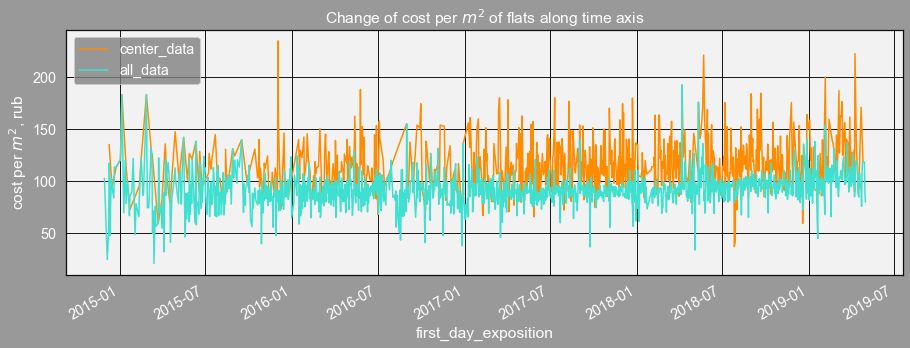

In [143]:
fig, ax = plt.subplots(figsize=(15,5))
data_center.pivot_table(index='first_day_exposition',
                        values='cost_per_m2',
                        aggfunc='median').plot(ax=ax, color=colors[0])
data.pivot_table(index='first_day_exposition',
                 values='cost_per_m2',
                 aggfunc='median').plot(ax=ax, color=colors[3])
plt.ylabel('cost per $m^2$, rub')
plt.title('Change of cost per $m^2$ of flats along time axis')
plt.legend(['center_data', 'all_data'], facecolor='0.5')
plt.show()

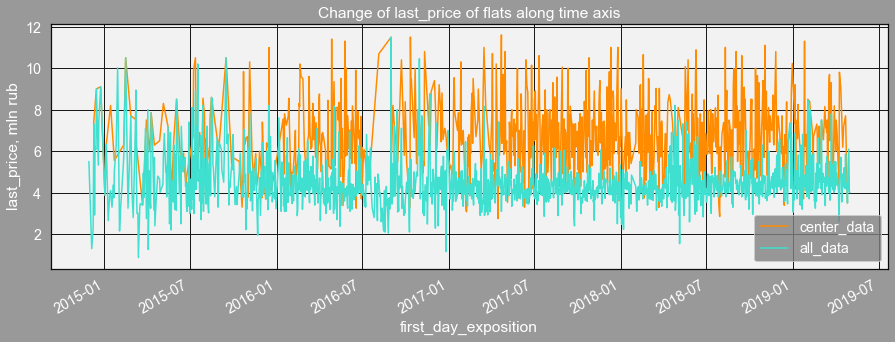

In [144]:
fig, ax = plt.subplots(figsize=(15,5))
data_center.pivot_table(index='first_day_exposition',
                        values='last_price',
                        aggfunc='median').plot(ax=ax, color=colors[0])
data.pivot_table(index='first_day_exposition',
                 values='last_price',
                 aggfunc='median').plot(ax=ax, color=colors[3])
plt.ylabel('last_price, mln rub')
plt.title('Change of last_price of flats along time axis')
plt.legend(['center_data', 'all_data'], facecolor='0.5')
plt.show()

В целом, закономерности в центре такие же, как и по всем данным:
1. Чем больше комнат, тем выше общая цена, но меньше цена за квадратный метр.
2. Медианная общая цена и цена за квадратный метр квартир на первых и последних этажах  немного ниже, чем на других.
3. При удаленности от центра средняя общая цена на квартиры падает.
4. Дата размещения не влияет на цену. Однако средняя цена в центре немного выше, чем по всей выборке (ожидаемо).

<a id="step_5"></a>

### Как зависит время продажи от цены за квадратный метр

Сделаем сводную таблицу,где группировать будем по сроку продажи, тогда значениями станут - средние цены за метр квартир, которые были проданы за этот срок:

In [145]:
data['days_exposition'].mean()

147.7514732257238

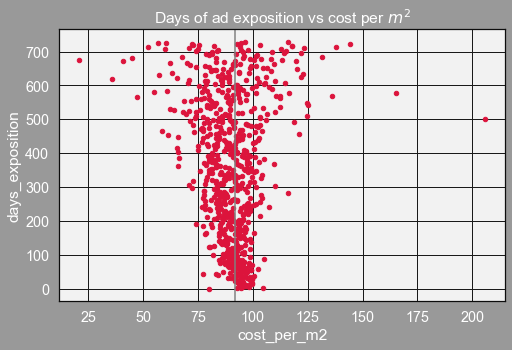

In [146]:
data.pivot_table(index='days_exposition', values='cost_per_m2').reset_index().plot(x='cost_per_m2',
                                                                                   y='days_exposition',
                                                                                   kind='scatter',
                                                                                   color=colors[2],
                                                                                   figsize=(8,5)
                                                                                  )
plt.axvline(data['cost_per_m2'].mean(), color=colors[1])
plt.title('Days of ad exposition vs cost per $m^2$')
plt.show()

Точки образуют достаточно плотное облако, где большая часть квартир продается менее чем за 200 дней по цене 90000руб.м2. Но есть квартиры, которые продаются дольше при той же цене. Дорогие квартиры быстрее не продаются :)

<a id='conclusions'></a>

## 4. Выводы

1. В исходных данных присутсвуют записи о самых разнообразных по параметрам квартирах. После удаления выбросов и аномалий,  а так же заполнения пропусков:
    - Большинство квартир имеют площадь от 40 до 60 метров, однако встречаются и очень маленькие (20-30 м2), и достаточно большие (100 м2) квартиры.
    - Самая дорогая квартира стоит около 12 млн.руб. Но большинство цен на квартиры находятся в диапазоне 3-6 млн.руб.
    - Однушек больше всех, но встречаются и пятерки.
    - Большинство квартир имеет высоту потолков 2.6-2.7 м. Но встречаются и высокие потолки, как в московских сталинках!
    - Большая часть квартир продается менее, чем за 202 дня. В среднем на это уходит 148 дней, но медианный срок - 90 дней. Все из-за наличия почти трех тысяч квартир, которые продаются больше года, смещая оценку среднего. Так же есть супер-быстрые продажи (за срок менее недели).
    
2. Изучение факторов, влияющих на цену квартир позволило сделать следующие выводы:
    - Наблюдается прямая пропорциональность между общей площадью квартиры и ее ценой (корреляция Пирсона 0.69)
    - Чем больше комнат, тем больше медианная цена квартиры.
    - Тип этажа (первый/последний/другой) вляет на цену: первый и послдений немного снижают ее медианную стоимость, однако эта гипотеза требует проверки на значимость, потому что разница в медианах, кажется, не сильно значимой.
    - Большая часть квартир располагается до 20 км от центра Санкт-Петербурга. Остальные расстояния представлены не многочисленно, поэтому сложно достоверно сказать о зависимости цены от удаленности. Интуитивно кажется, что чем дальше, чем дешевле.
    - В среднем цена не зависит от дня недели, месяца или года, в который была сделана публикация.
    - Средняя цена в центре немного выше, чем по всей выборке.
3. Квартиры из центра города показывают те же закономерности, что и общая выборка.
4. Срок, за который будет продана квартира, кажется зависит от цены. На графике цены за метр против срока продажи: видно, большая часть квартир продается менее чем за 200 дней по цене примерно 90000руб/м2. Но есть квартиры, которые продаются дольше при той же цене. Дорогие квартиры быстрее не продаются.

5. *В целом, для построения модели предсказания цены необходимо провести качественный отбор признаков. Потому что, например, кажется, что если квартира-студия, то она будет стоить дороже. Однако, квартиры студии при этом располагаются в новостройках, которые априори дороже. Такой информации у нас нет.*